Plan działania:

1. Klasteryzacja sklepów - Hubert
2. Badanie zbioru + budowa modeli
2.1 XGBoost Regresor - Hubert
2.2 Random Forest Regresor - Błażej
2.2. SVM - Jonasz 
2.3. Preprocessing datasetu
3. Sieci rekurencyjne - szeregi czasowe - budowa sieci Jonasz/Błażej/Hubert
4. Prezentacja 
4.1 Szablon - Hubert
4.2 Uzupełnienie wartości merytorycznej Jonasz/Błażej/Hubert 
5. Aplikacja - Angelika

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [27]:
df = pd.read_csv("Walmart.csv")

In [28]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [29]:
df_2 = df[['Store', 'Date',  'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment','Weekly_Sales']]

In [30]:
df_2

,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales
0,1,05-02-2010,0,42.31,2.572,211.096358,8.106,1643690.90
1,1,12-02-2010,1,38.51,2.548,211.242170,8.106,1641957.44
2,1,19-02-2010,0,39.93,2.514,211.289143,8.106,1611968.17
3,1,26-02-2010,0,46.63,2.561,211.319643,8.106,1409727.59
4,1,05-03-2010,0,46.50,2.625,211.350143,8.106,1554806.68
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,0,64.88,3.997,192.013558,8.684,713173.95
6431,45,05-10-2012,0,64.89,3.985,192.170412,8.667,733455.07
6432,45,12-10-2012,0,54.47,4.000,192.327265,8.667,734464.36
6433,45,19-10-2012,0,56.47,3.969,192.330854,8.667,718125.53


In [31]:
correlation_matrix = np.round(df_2.corr(), 2)

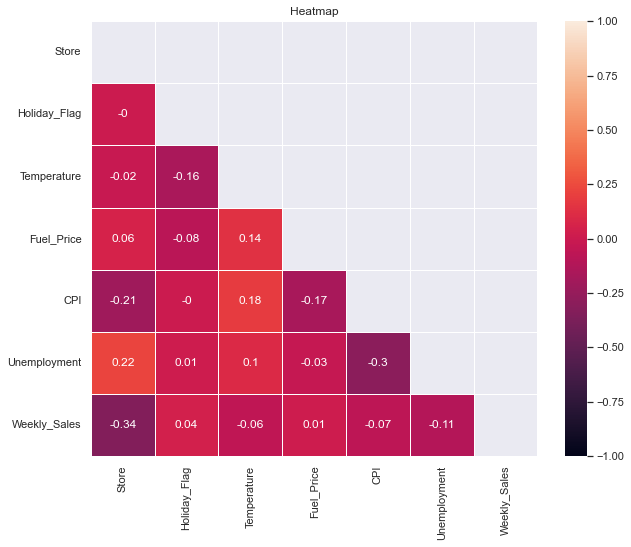

In [32]:
sns.set(rc={'figure.figsize':(10,8)}) # okrślenie rozmiaru rysunku
color_map = sns.diverging_palette(240, 10, n=10) # wybór mapy kolorów
mask = np.triu(np.ones_like(correlation_matrix), k=0) # maska - ukrycie górnej macierzy trójkątnej
sns.heatmap(correlation_matrix, mask = mask, linewidths=.5, annot=True, vmin=-1., vmax=1.)#, square=True) # wykonanie wykresu
plt.title("Heatmap")
pass

In [33]:
df_indexed = df_2.set_index("Date")

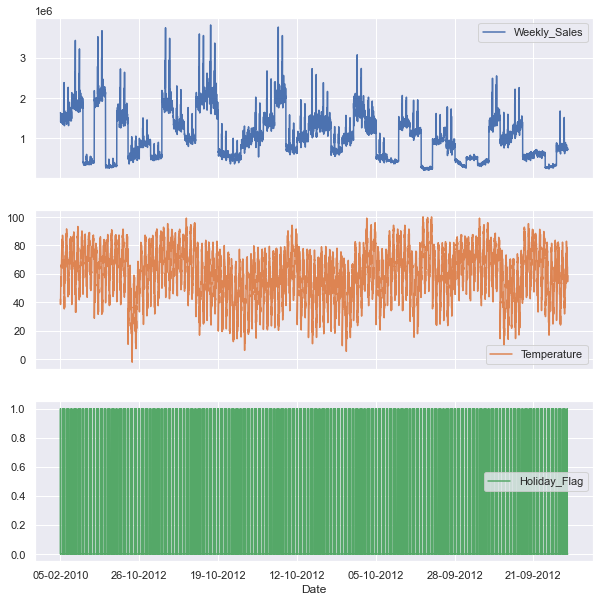

In [34]:
future_check = df_indexed[["Weekly_Sales", "Temperature", 'Holiday_Flag']]
future_check.plot(figsize=(10,10), subplots=True)
pass

In [35]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [37]:
df.sort_values("Date", ascending=False)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
4623,33,31-12-2010,219804.85,1,52.91,3.148,127.087677,9.265
2335,17,31-12-2010,635862.55,1,20.79,2.868,127.087677,6.885
1906,14,31-12-2010,1623716.46,1,29.67,3.179,182.571448,8.724
3479,25,31-12-2010,623092.54,1,25.89,3.179,204.643227,7.484
5624,40,31-12-2010,811318.30,1,19.29,3.177,132.815032,5.287
...,...,...,...,...,...,...,...,...
632,5,01-04-2011,314316.55,0,61.50,3.524,215.402441,6.489
2062,15,01-04-2011,542556.05,0,30.34,3.811,134.068258,7.658
1061,8,01-04-2011,878762.30,0,49.86,3.524,218.258628,6.297
4493,32,01-04-2011,1051121.02,0,44.83,3.461,192.269171,8.595


In [38]:
df.shape

(6435, 8)

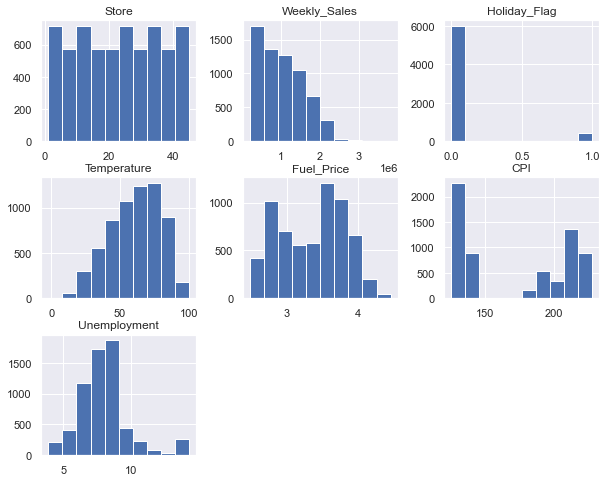

In [39]:
df.hist()
pass

In [40]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [41]:
data = df["Weekly_Sales"].to_numpy().reshape(-1,1)

In [42]:
km = KMeans(n_clusters=3, max_iter = 100, n_init=10)
km.fit(data)
df["cluster_sklearn"] = km.labels_

In [43]:
df["cluster_sklearn"]

0       1
1       1
2       1
3       2
4       1
       ..
6430    0
6431    0
6432    0
6433    0
6434    0
Name: cluster_sklearn, Length: 6435, dtype: int32

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
df = df.drop(columns=df[["Date", "cluster_sklearn"]], axis=1)

In [46]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [47]:
my_scaler = StandardScaler()
df_norm = pd.DataFrame(my_scaler.fit_transform(df))
df_norm.head()

,0,1,2,3,4,5,6
0,-1.693979,1.057420,-0.274204,-0.995136,-1.713800,1.004175,0.056964
1,-1.693979,1.054348,3.646917,-1.201170,-1.766089,1.007880,0.056964
2,-1.693979,1.001206,-0.274204,-1.124178,-1.840166,1.009074,0.056964
3,-1.693979,0.642828,-0.274204,-0.760907,-1.737766,1.009849,0.056964
4,-1.693979,0.899914,-0.274204,-0.767955,-1.598328,1.010624,0.056964


In [48]:
distortions = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df)
    distortions.append(km.inertia_)

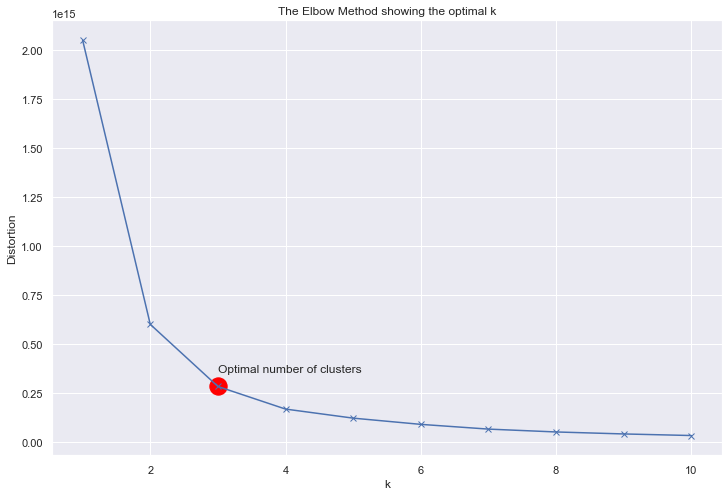

In [49]:
plt.figure(figsize=(12,8))
plt.plot(K, distortions, 'bx-')
plt.scatter(x = 3, y = distortions[2], s = 300, color = "red")
plt.annotate("Optimal number of clusters", (3, distortions[2]*1.25))
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [50]:
df_sales = df["Weekly_Sales"].to_numpy().reshape(-1,1)

In [51]:
my_scaler = StandardScaler()
df_norm = pd.DataFrame(my_scaler.fit_transform(df_sales))

In [52]:
df.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

In [53]:
from sklearn.preprocessing import MinMaxScaler

In [54]:
scaler = MinMaxScaler()
x1 = scaler.fit_transform(df["Weekly_Sales"].to_numpy().reshape(-1,1))
x2 = scaler.fit_transform(df["Temperature"].to_numpy().reshape(-1,1))

df_final = np.concatenate([x1, x2], axis=1)

In [55]:
km2 = KMeans(n_clusters=6, init="k-means++", max_iter = 100, n_init=10)
km2.fit(df_final)

df["cluster"] = km2.labels_

In [56]:
df_clusters = df["cluster"].to_numpy().reshape(-1,1)

df_final2 = np.concatenate([df_final, df_clusters], axis=1)

In [57]:
df_final2

array([[0.39729115, 0.43414873, 2.        ],
       [0.39681079, 0.39696673, 2.        ],
       [0.38850052, 0.41086106, 2.        ],
       ...,
       [0.14533712, 0.55313112, 4.        ],
       [0.1408095 , 0.57270059, 4.        ],
       [0.15249124, 0.59598826, 4.        ]])

In [58]:
df_df = pd.DataFrame(df_final2)

df_class0 = df_df[df_df[2] == 0]
df_class1 = df_df[df_df[2] == 1]
df_class2 = df_df[df_df[2] == 2]

In [59]:
df_class0_array = df_class0.to_numpy()
df_class1_array = df_class1.to_numpy()
df_class2_array = df_class2.to_numpy()

In [60]:
df_class0_array

array([[0.05705213, 0.68551859, 0.        ],
       [0.04018261, 0.67553816, 0.        ],
       [0.03602139, 0.68424658, 0.        ],
       ...,
       [0.14529099, 0.75489237, 0.        ],
       [0.15421797, 0.76086106, 0.        ],
       [0.13640701, 0.68424658, 0.        ]])

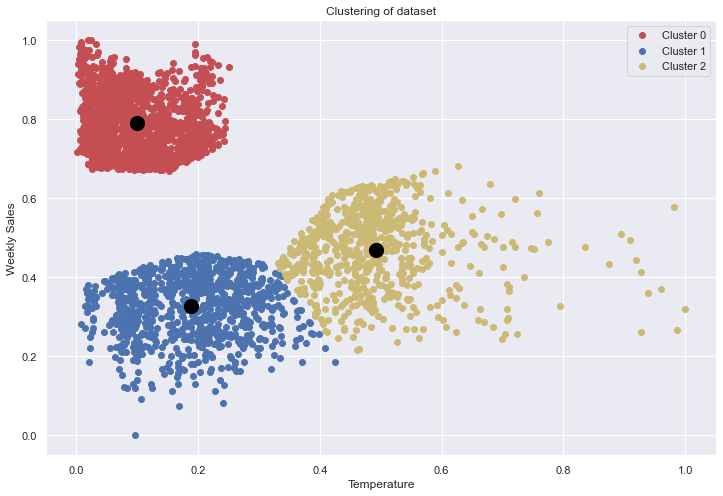

In [68]:
kmeans0 = KMeans(n_clusters = 1,                 # Set amount of clusters
                init = 'k-means++',             # Initialization method for kmeans
                max_iter = 300,                 # Maximum number of iterations
                n_init = 10,                    # Choose how often algorithm will run with different centroid
                random_state = 0)               # Choose random state for reproducibility
kmeans1 = KMeans(n_clusters = 1,                 # Set amount of clusters
                init = 'k-means++',             # Initialization method for kmeans
                max_iter = 300,                 # Maximum number of iterations
                n_init = 10,                    # Choose how often algorithm will run with different centroid
                random_state = 0)               # Choose random state for reproducibility
kmeans2 = KMeans(n_clusters = 1,                 # Set amount of clusters
                init = 'k-means++',             # Initialization method for kmeans
                max_iter = 300,                 # Maximum number of iterations
                n_init = 10,                    # Choose how often algorithm will run with different centroid
                random_state = 0)               # Choose random state for reproducibility                             


kmeans0.fit_predict(df_class0)
kmeans1.fit_predict(df_class1)
kmeans2.fit_predict(df_class2)

plt.figure(figsize=(12,8))
# # Plot the data
plt.scatter(df_class0_array[:,0], 
            df_class0_array[:,1],
            c = "r")
plt.scatter(df_class1_array[:,0], 
            df_class1_array[:,1],
            c = "b")
plt.scatter(df_class2_array[:,0], 
            df_class2_array[:,1],
            c = "y")

# Plot the clusters 
plt.scatter(kmeans0.cluster_centers_[:, 0], 
            kmeans0.cluster_centers_[:, 1], 
            s=200,                             # Set centroid size
            c='black')                           # Set centroid color
plt.scatter(kmeans1.cluster_centers_[:, 0], 
            kmeans1.cluster_centers_[:, 1], 
            s=200,                             # Set centroid size
            c='black')                           # Set centroid color
plt.scatter(kmeans2.cluster_centers_[:, 0], 
            kmeans2.cluster_centers_[:, 1], 
            s=200,                             # Set centroid size
            c='black')                           # Set centroid color

classes = ["Cluster 0", "Cluster 1", "Cluster 2"]
plt.legend(labels=classes)
plt.title("Clustering of dataset")
plt.xlabel("Temperature")
plt.ylabel("Weekly Sales")
plt.show()

In [ ]:
class_0 = df[df["cluster_sklearn"] == 0]
class_0

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
286,3,05-02-2010,461622.22,0,45.71,2.572,214.424881,7.368,0
287,3,12-02-2010,420728.96,1,47.93,2.548,214.574792,7.368,0
288,3,19-02-2010,421642.19,0,47.07,2.514,214.619887,7.368,0
289,3,26-02-2010,407204.86,0,52.05,2.561,214.647513,7.368,0
290,3,05-03-2010,415202.04,0,53.04,2.625,214.675139,7.368,0
...,...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684,0
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667,0
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667,0
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667,0


In [ ]:
class_1 = df[df["cluster_sklearn"] == 1]
class_1

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,1
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,1
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,1
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,1
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808,1
...,...,...,...,...,...,...,...,...,...
5816,41,09-12-2011,1548661.45,0,17.05,3.331,195.874257,6.759,1
5817,41,16-12-2011,1682368.32,0,25.01,3.266,195.984169,6.759,1
5818,41,23-12-2011,2263722.68,0,25.59,3.173,196.171389,6.759,1
5852,41,17-08-2012,1560590.05,0,65.77,3.545,198.100106,6.432,1


In [ ]:
class_2 = df[df["cluster_sklearn"] == 2]
class_2

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,2
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106,2
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106,2
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106,2
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808,2
...,...,...,...,...,...,...,...,...,...
6390,45,23-12-2011,1521957.99,0,42.27,3.389,188.929975,8.523,2
6391,45,30-12-2011,869403.63,1,37.79,3.389,189.062016,8.523,2
6398,45,17-02-2012,858853.75,0,36.85,3.695,189.842483,8.424,2
6405,45,06-04-2012,899479.43,0,49.73,3.996,190.685171,8.567,2


In [ ]:
print(np.max(class_1["Weekly_Sales"]))
print(np.min(class_1["Weekly_Sales"]))
print(class_1.shape[0])

3818686.45
1548033.78
1262


In [ ]:
print(np.max(class_0["Weekly_Sales"]))
print(np.min(class_0["Weekly_Sales"]))
print(class_0.shape[0])

841951.91
209986.25
2683


In [ ]:
print(np.max(class_2["Weekly_Sales"]))
print(np.min(class_2["Weekly_Sales"]))
print(class_2.shape[0])

1547729.24
843361.1
2490


In [ ]:
file_name = "Walmart_klasy.csv"
df.to_csv(file_name)


In [ ]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,1
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,1
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,1
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,2
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,1


In [ ]:
data_2 = df[["Store", "Weekly_Sales"]]

In [ ]:
km = KMeans(n_clusters=3, max_iter = 100, n_init=10)
km.fit(data_2)
df["cluster_sklearn"] = km.labels_

In [ ]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,1
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,1
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,1
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,2
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,1
...,...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684,0
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667,0
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667,0
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667,0


In [ ]:
df_Store_1 = df[df["Store"] == 1]

In [ ]:
file_name = "Walmart_Store_1.xlsx"
df.to_csv(file_name)